# Datasets

In [1]:
from sklearn.datasets import load_iris, fetch_california_housing, load_diabetes

# iris = load_iris(return_X_y=True, as_frame=True)[0]
housing = fetch_california_housing(return_X_y=True, as_frame=True)[0]
# diabetes = load_diabetes(return_X_y=True, as_frame=True)[0]

In [2]:
# iris

In [3]:
housing

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [4]:
# diabetes

# Super Class and Utils

## Feature

In [5]:
from math import log, e
import numpy as np
import pandas as pd

class feature():

    @staticmethod
    def get_count(data):
        """
        equivalent to return len(data), data.value_counts()
        """
        n_labels = len(data)     
        value, counts = np.unique(data, return_counts=True)
        return n_labels, (value, counts)
    
    # def entropy_scipy(probs):
    #      # `pd.Series` with scipy
    #     p_data = data.value_counts()           # counts occurrence of each value 
    #     return  scipy.stats.entropy(p_data)    # get entropy from counts
    #     # return  scipy.stats.entropy(probs)    # get entropy from prob
     
    @staticmethod
    def entropy_numpy(n_labels, freq, base=2):
    # def entropy_numpy(probs, base=2):
        """ Computes entropy of label distribution with numpy. """

        if n_labels <= 1:
            return 0 
        probs = freq / n_labels
        probs = probs[probs>0]
        
        n_classes = np.count_nonzero(probs)        
        if n_classes <= 1:
            return 0
        
        # Compute entropy
        # base = e if base is None else base
        ent = 0.
        for prob in probs:
            ent -= prob * log(prob, base)
        return ent

    @staticmethod
    def get_data_type(series: pd.Series) -> str:
        # Check if the series is empty
        if series.empty:
            return "Empty"
        
        # Check if the series is of datetime type
        if pd.api.types.is_datetime64_any_dtype(series):
            return "Datetime"
        
        # Check if the series is boolean
        if pd.api.types.is_bool_dtype(series):
            return "Binary"
        
        # Check if the series is numeric (int or float)
        if pd.api.types.is_numeric_dtype(series):
            # If there are only 2 unique values, treat as binary
            if series.nunique() == 2:
                return "Binary"
            else:
                return "Continuous"
        
        # If the series is an object (e.g., strings or mixed types)
        if pd.api.types.is_object_dtype(series):
            unique_values = series.nunique()
            total_values = len(series)
            
            # Consider the series categorical if unique values are relatively small
            if unique_values / total_values < 0.05:
                return "Categorical"
            else:
                return "Text"
        
        return "Unknown"

## Viz

In [27]:
from abc import ABC, abstractmethod, ABCMeta
import matplotlib.pyplot as plt

class Viz(ABC):
    """
    Abstract base class for creating different types of visualizations.
    
    Attributes:
    -----------
    data_type : tuple
        A tuple representing the data type of the columns in the DataFrame or Series.
    column_name : tuple
        A tuple containing the names of the columns.
    feature : Any
        The computed feature for the visualization (defined in child classes).
    """
    
    def __init__(self, column_data: pd.DataFrame | pd.Series):
        
        if isinstance(column_data, pd.Series):
            # Convert Series to DataFrame
            column_data = column_data.to_frame()
        elif not isinstance(column_data, pd.DataFrame):
            # Raise an error if the input is not a DataFrame or Series
            raise TypeError("Expected column_data to be a pandas DataFrame or Series")
        
        self.data_type   = tuple(feature.get_data_type(data) for _, data in column_data.items())
        self.column_name = tuple(column_name for column_name in column_data)
        self.feature     = self._compute_feature()
          
    @abstractmethod
    def get_params(self):
        """
        Abstract method to return the parameters of the visualization.
        This must be implemented by subclasses.
        
        Returns:
        --------
        dict
            A dictionary of parameters related to the visualization.
        """

    @abstractmethod
    def _compute_feature(self):
        """
        Abstract method to compute a feature of the data.
        This must be implemented by subclasses.
        
        Returns:
        --------
        Any
            The computed feature based on the data.
        """
        pass

    @abstractmethod
    def plt(self, **kwargs):
        """
        Abstract method to plot the visualization.
        This must be implemented by subclasses.

        Parameters:
        -----------
        **kwargs : optional
            Additional keyword arguments for customizing the plot.
        """
        pass

## Viz Selector

In [7]:
from itertools import combinations

class VizSelector():

    def __init__(self, vizs: Viz):
        """Initialize with a list of visualization objects"""
        self.vizs = vizs

    @classmethod
    def hist(cls, df: pd.DataFrame):
        """Create VizSelector for 1D visualizations (e.g., Histograms)"""
        vizs = [Histogram(data) for _, data in df.items()]
        return cls(vizs)

    @classmethod
    def scatter(cls, df: pd.DataFrame):
        """Create VizSelector for 2D visualizations (e.g., Scatter plots)"""
        column_pairs = combinations(df.columns, 2)
        vizs = [Scatter(df[[x, y]]) for x, y in column_pairs]
        return cls(vizs)

    @classmethod
    def create(cls, df: pd.DataFrame, viz_type: str):
        """Factory method to choose correct visualization type"""
        model_map = {
            "hist": cls.hist,
            "scatter": cls.scatter
        }
        if viz_type not in model_map:
            raise ValueError(f"Unknown visualization type: {viz_type}")
        return model_map[viz_type](df)
    
    def rank(self):
        vizs_sorted = sorted(self.vizs, key=lambda x: x.get_params()["feature"], reverse=True)
        return vizs_sorted
    
    def rank5(self):
        return self.rank()[:5]
    
    def plt(self):
        _, axs = plt.subplots(1, 5, figsize=(20, 4))
        for idx, obj in enumerate(self.rank5()):
            obj.plt(axs=axs[idx])

# 1D

## Histogram

In [36]:
class Histogram(Viz):

    def __init__(self, column_data: pd.Series):
        #
        # self.data_len, self.data_freq = feature.get_count(column_data)
        self.data_len = len(column_data)
        self.frequency, self.bins = np.histogram(column_data, bins=10, range=[(column_data.min() if column_data.min() < 0 else 0 ), column_data.max()], density=False)
        super().__init__(column_data)

    def _compute_feature(self):
        """Calculates entropy"""
        # TODO timeit 
        # scipy_entr = feature.entropy_scipy(self.data_len, self.frequency)
        numpy_entr = feature.entropy_numpy(self.data_len, self.frequency)

        # print(scipy_entr, numpy_entr)
        return numpy_entr

    def get_params(self):
        # return self.feature, self.data_len, self.data_freq
        return {"feature": self.feature, "params": (self.frequency, self.bins)}

    def plt(self, **kwargs):
        if 'axs' in kwargs :
            kwargs["axs"].bar(self.bins[:-1], self.frequency, width=np.diff(self.bins), edgecolor="black", align="edge")
            kwargs["axs"].set_title(f"{self.column_name[0]}")
        else:
            ## Printar linha y com a distribuição
            plt.bar(self.bins[:-1], self.frequency, width=np.diff(self.bins), edgecolor="black", align="edge")
            plt.title(f"{self.column_name[0]}")

            # plt.stairs(self.frequency, self.bins, fill=True)


In [37]:
hist_obj = Histogram(housing["HouseAge"])

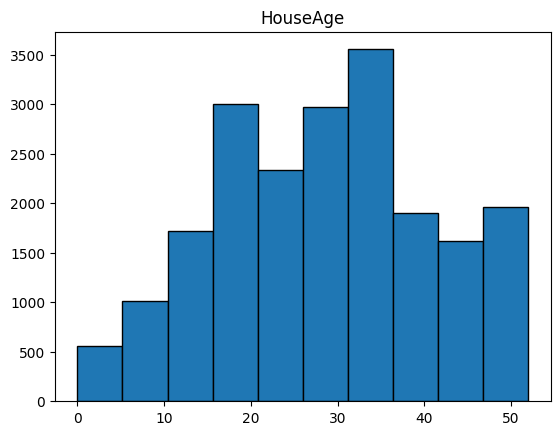

In [38]:
hist_obj.plt()

In [11]:
# hist_obj.get_params()

In [12]:
# hist_obj.data_type

## Box plot

In [13]:
class BoxPlot(Viz):

    def __init__(self, column_data):
        self.data_len = len(column_data)
        self.params  = BoxPlot.calculate_boxplot_params(column_data)
        super().__init__(column_data)
    
    def calculate_boxplot_params(series: pd.Series) -> dict:
        """
        Calculate the boxplot parameters (min, Q1, median, Q3, max, and outliers) from a pandas Series.
        """
        q1 = series.quantile(0.25)
        median = series.median()
        q3 = series.quantile(0.75)
        iqr = q3 - q1  # Interquartile range
        whisker_low = q1 - 1.5 * iqr
        whisker_high = q3 + 1.5 * iqr
        
        # Calculate min and max within the whiskers
        min_val = series[series >= whisker_low].min()
        max_val = series[series <= whisker_high].max()
        
        # Identify outliers (fliers)
        outliers = series[(series < whisker_low) | (series > whisker_high)].values
    
        return {
            'whislo': whisker_low,   # Bottom whisker position
            'q1': q1,        # First quartile (25th percentile)
            'med': median,   # Median (50th percentile)
            'q3': q3,        # Third quartile (75th percentile)
            'whishi': whisker_high,   # Top whisker position
            'fliers': outliers  # Outliers
            }
        
    def _compute_feature(self):
        """Calculates """
        # pass
        return 0

    def get_params(self):
        # return self.feature, self.data_len, self.data_freq
        return {"feature": self.feature, **self.params}

    def plt(self, **kwargs):
        if 'axs' in kwargs :
            kwargs["axs"].bar(self.bins[:-1], self.frequency, width=np.diff(self.bins), edgecolor="black", align="edge")
        else:
            # plt.boxplot(column_data, patch_artist=True)  # fill with random  color
            fig, ax = plt.subplots()
            ax.bxp([self.params], showfliers=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
            ax.set_xticks([1], [self.column_name], rotation=45) # Rotaciona o rótulo do eixo x 

In [14]:
box_obj = BoxPlot(housing["HouseAge"])

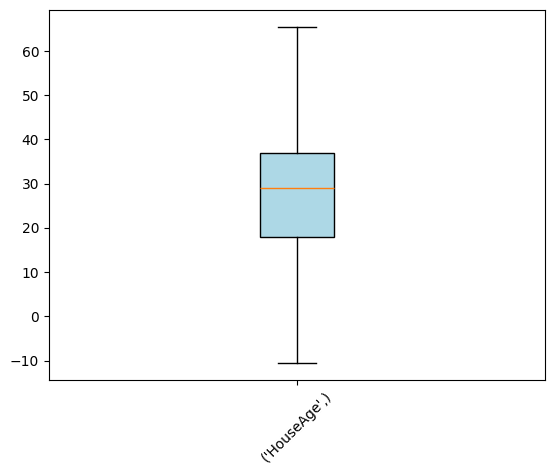

In [15]:
box_obj.plt()

In [16]:
# box_obj.get_params()

In [17]:
# box_obj.data_type

In [18]:
# plt.boxplot(housing["HouseAge"], patch_artist=True, boxprops=dict(facecolor='lightblue')) 
# plt.xticks([1], ["HouseAge"], rotation=45) # Rotaciona o rótulo do eixo x
# plt.show()

# 2D

## ScatterPlot

In [29]:
from scipy.stats import pearsonr   

class Scatter(Viz):

    def __init__(self, data: pd.DataFrame):
        self.x, self.y = data.T.values
        super().__init__(data)

    def _compute_feature(self):
        """Calculates corr"""
        # TODO timeit 
        corr = pearsonr(self.x, self.y)
        return corr

    def get_params(self):
        return {"feature": self.feature, "params": None}

    def plt(self, **kwargs):
        if 'axs' in kwargs :
            kwargs["axs"].scatter(self.x, self.y)
            kwargs["axs"].set_title(f"{self.column_name[0]} x {self.column_name[1]}")
        else:
            ## Printar linha y com a distribuição
            plt.scatter(self.x, self.y)
                

In [30]:
obj = Scatter(housing[["HouseAge","MedInc"]])

In [31]:
obj.get_params()

{'feature': PearsonRResult(statistic=np.float64(-0.11903398993785667), pvalue=np.float64(5.185138325252411e-66)),
 'params': None}

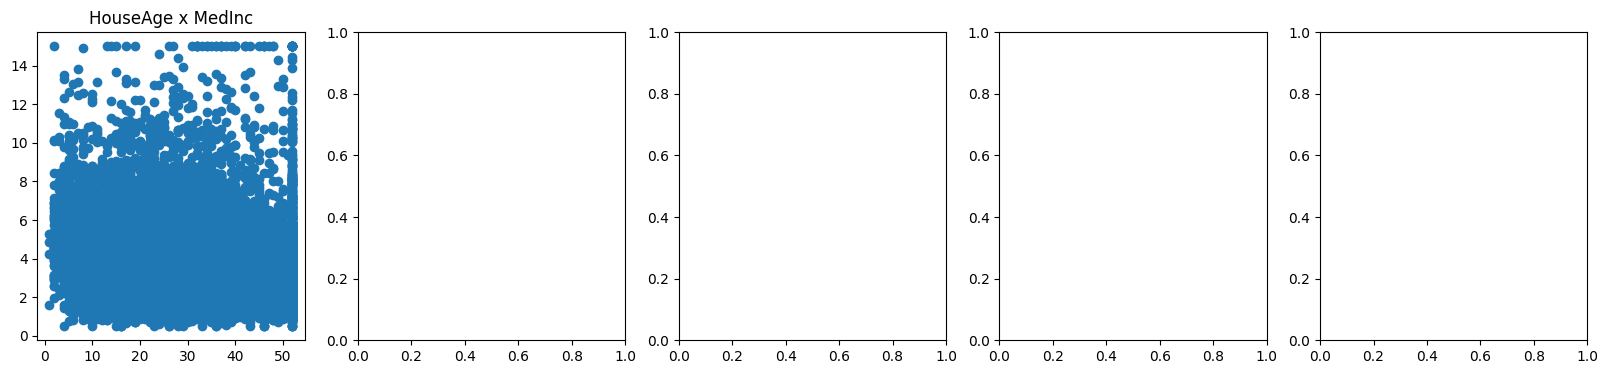

In [32]:
_, axs = plt.subplots(1, 5, figsize=(20, 4))
# axs[0].scatter(obj.x, obj.y)
obj.plt(axs=axs[0])

# Tests

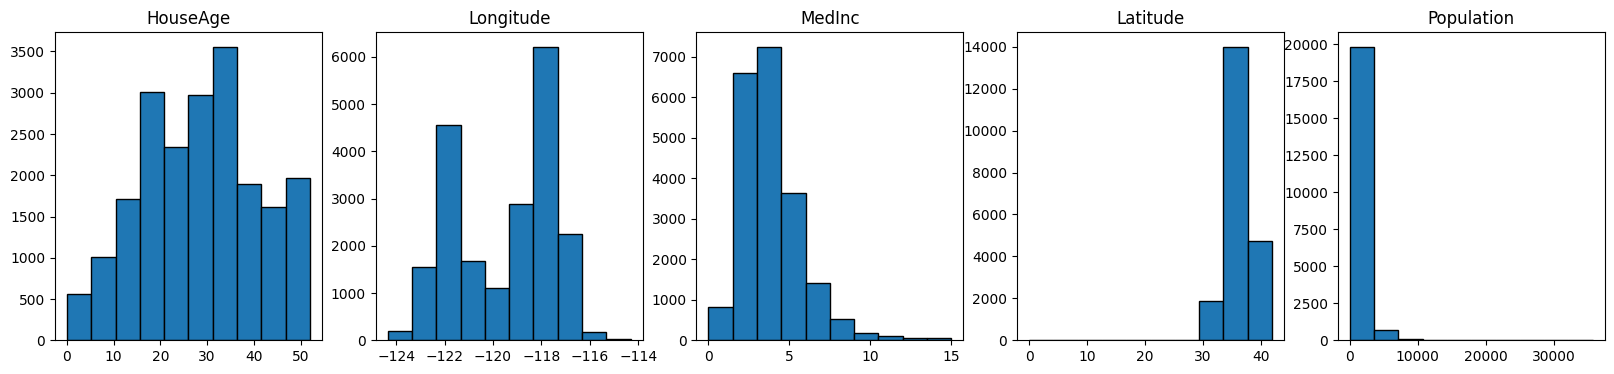

In [28]:
obj = VizSelector.create(housing, 'hist')
top5 = obj.rank5()
# list(map(lambda x: x.get_params()["feature"], obj.rank5()))
obj.plt()

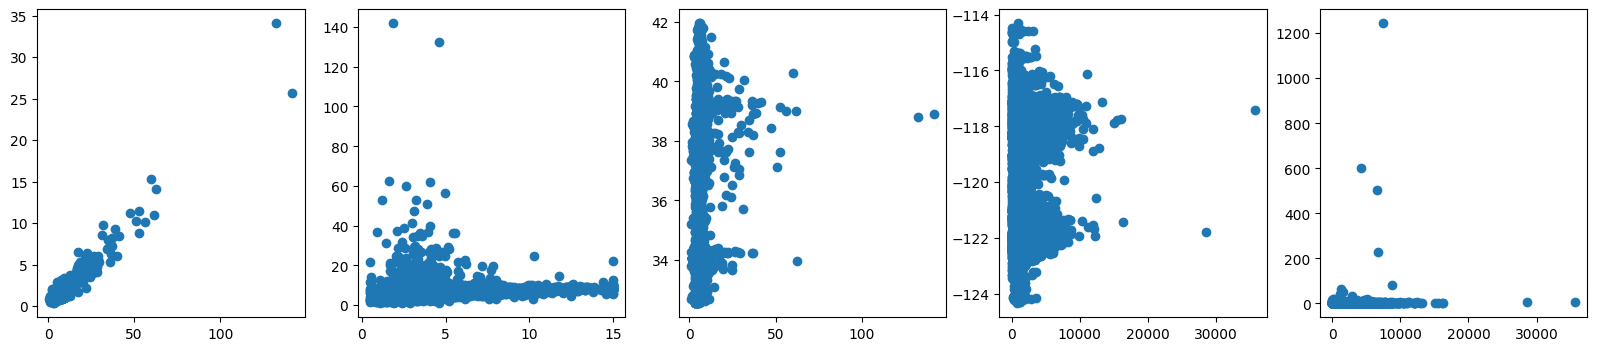

In [24]:
obj = VizSelector.create(housing, 'scatter')
top5 = obj.rank5()
# list(map(lambda x: x.get_params()["feature"], obj.rank5()))
obj.plt()

In [25]:
obj = VizSelector.create(housing, 'box')
top5 = obj.rank5()
# list(map(lambda x: x.get_params()["feature"], obj.rank5()))
obj.plt()

ValueError: Unknown visualization type: box

In [25]:
list(map(lambda x: x.column_name, obj.rank5()))

[('HouseAge',), ('Longitude',), ('MedInc',), ('Latitude',), ('Population',)]